## Advanced Stats Final Project: Hotel ADR Forecasting
ADR: Average Daily Rate.
xinyu.hou.1@vanderbilt.edu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

## Pick a Time Series Variable of Interest

This dataset contains hotel demand data for two types of hotels: a resort hotel (H1) with 40,060 observations and a city hotel (H2) with 79,330 observations, totaling 119,390 bookings. Each record represents a hotel booking with 31 variables capturing booking details, customer characteristics, and stay information. The data spans arrivals between July 1, 2015, and August 31, 2017, including both completed and canceled bookings. All sensitive information related to hotel and customer identification has been anonymized. These datasets are valuable resources for research and education in areas such as revenue management, machine learning, and data mining.


https://www.sciencedirect.com/science/article/pii/S2352340918315191


https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand?resource=download

### Dataset Overview:
- **Dataset Size**: 119,390 rows and 19 columns.
- **Column Names**:
  - `hotel`: Type of hotel (e.g., Resort Hotel, City Hotel).
  - `is_canceled`: Whether the booking was canceled (1 for yes, 0 for no).
  - `lead_time`: Days between booking date and arrival date.
  - `arrival_date`: Full date of arrival.
  - `arrival_date_year`: Year of the arrival date.
  - `arrival_date_month`: Month of the arrival date.
  - `arrival_date_week_number`: Week number of the arrival date.
  - `arrival_date_day_of_month`: Day of the month of arrival.
  - `stays_in_weekend_nights`: Number of weekend nights in the stay.
  - `stays_in_week_nights`: Number of weekday nights in the stay.
  - `adults`: Number of adults in the booking.
  - `children`: Number of children in the booking.
  - `babies`: Number of babies in the booking.
  - `market_segment`: Source of booking (e.g., Direct, Online Travel Agent).
  - `distribution_channel`: Booking distribution channel (e.g., Direct, TA/TO).
  - `customer_type`: Type of customer (e.g., Transient, Contract).
  - `adr`: Average Daily Rate, indicating the price paid for the stay.
  - `reservation_status`: Current status of the booking (e.g., Check-Out, No-Show).
  - `reservation_status_date`: Date of the reservation status update.

### Missing Data:
- The dataset contains missing values for:
  - `children`: 4 missing values.

This dataset provides a comprehensive foundation for analyzing booking patterns, customer behaviors, and revenue metrics for hotel management, providing a rich foundation for exploring trends, seasonality, and forecasting models to analyze and predict hotel demand.


In [2]:
# Load dataset
hotel_data = pd.read_csv('./Hotel_booking.csv')

# Overview of the dataset
print(hotel_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   hotel                      119390 non-null  object 
 1   is_canceled                119390 non-null  int64  
 2   lead_time                  119390 non-null  int64  
 3   arrival_date               119390 non-null  object 
 4   arrival_date_year          119390 non-null  int64  
 5   arrival_date_month         119390 non-null  int64  
 6   arrival_date_week_number   119390 non-null  int64  
 7   arrival_date_day_of_month  119390 non-null  int64  
 8   stays_in_weekend_nights    119390 non-null  int64  
 9   stays_in_week_nights       119390 non-null  int64  
 10  adults                     119390 non-null  int64  
 11  children                   119386 non-null  float64
 12  babies                     119390 non-null  int64  
 13  market_segment             11

In [3]:
hotel_data.head(5)

,hotel,is_canceled,lead_time,arrival_date,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,market_segment,distribution_channel,customer_type,adr,reservation_status,reservation_status_date
0,Resort Hotel,0,109,1/1/2016,2016,1,1,1,0,1,2,0.0,0,Online TA,TA/TO,Transient-Party,59.94,Check-Out,1/2/2016
1,Resort Hotel,0,109,1/1/2016,2016,1,1,1,0,1,2,2.0,0,Online TA,TA/TO,Transient-Party,116.10,Check-Out,1/2/2016
2,Resort Hotel,1,2,1/1/2016,2016,1,1,1,0,1,2,0.0,0,Online TA,TA/TO,Transient,89.00,No-Show,1/1/2016
3,Resort Hotel,0,88,1/1/2016,2016,1,1,1,0,2,2,0.0,0,Online TA,TA/TO,Transient,73.46,Check-Out,1/3/2016
4,Resort Hotel,1,20,1/1/2016,2016,1,1,1,0,2,2,2.0,0,Online TA,TA/TO,Transient,119.00,Canceled,12/22/2015


In [4]:
print(hotel_data.describe())

         is_canceled      lead_time  arrival_date_year  arrival_date_month  \
count  119390.000000  119390.000000      119390.000000       119390.000000   
mean        0.370416     104.011416        2016.156554            4.653405   
std         0.482918     106.863097           0.707476            2.871772   
min         0.000000       0.000000        2015.000000            1.000000   
25%         0.000000      18.000000        2016.000000            2.000000   
50%         0.000000      69.000000        2016.000000            5.000000   
75%         1.000000     160.000000        2017.000000            7.000000   
max         1.000000     737.000000        2017.000000           12.000000   

       arrival_date_week_number  arrival_date_day_of_month  \
count             119390.000000              119390.000000   
mean                  27.165173                  15.798241   
std                   13.605138                   8.780829   
min                    1.000000                  

In [5]:
# Impute missing values in the 'children' column with the mean
mean_value_children = hotel_data['children'].mean()
hotel_data['children'].fillna(mean_value_children, inplace=True)

# Impute 'adr' with the mean value
mean_value_adr = hotel_data['adr'].mean()
hotel_data['adr'].fillna(mean_value_adr, inplace=True)

# Impute 'reservation_status' and 'reservation_status_date' with forward fill (assuming time-based data continuity)
hotel_data['reservation_status'].fillna(method='ffill', inplace=True)
hotel_data['reservation_status_date'].fillna(method='ffill', inplace=True)

# Verify if missing values are handled
missing_after_imputation = hotel_data.isnull().sum()
missing_after_imputation


<ipython-input-5-2f56e0cfb675>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hotel_data['children'].fillna(mean_value_children, inplace=True)
<ipython-input-5-2f56e0cfb675>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

,0
hotel,0
is_canceled,0
lead_time,0
arrival_date,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0


## 1. How Does the Time Series Look?
### Visualize the trend and seasonality



### Time Series of Average Price (ADR):
Illustrates the weekly movement of average room prices over time, highlighting fluctuations, seasonal patterns, and long-term trends in pricing.

### Decomposition of Average Price by **weeks and months**:
1. **Trend**: Shows consistent upward or downward movements in ADR over the observed weekly period.
2. **Seasonality**: Captures repeating weekly patterns, reflecting changes in seasonal demand.
3. **Residuals**: Represents random variations not explained by the trend or seasonal components.

These visualizations collectively emphasize the seasonal variations and long-term trends in ADR, offering valuable insights into pricing strategies, guest preferences, and booking dynamics. Let me know if you need further analysis or adjustments!

### Group ADR by week

<ipython-input-6-0ebd075b6551>:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  adr_weekly_filled = adr_weekly.fillna(method='ffill')  # Forward fill missing values


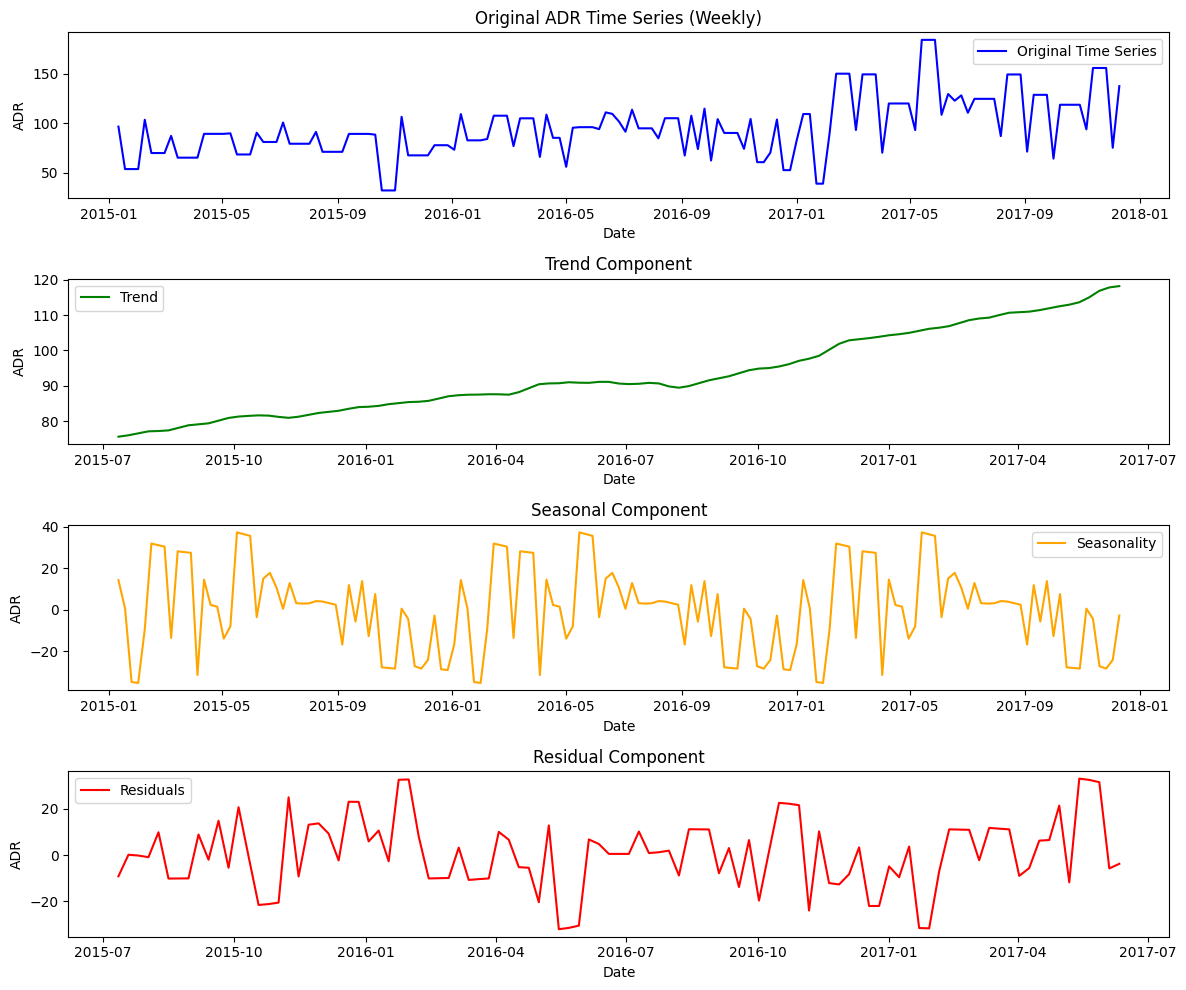

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
data = hotel_data.copy()

# Convert arrival_date to datetime for easier time series handling
data['arrival_date'] = pd.to_datetime(data['arrival_date'], errors='coerce')

# Group by arrival_date and calculate the mean ADR
adr_time_series_data = data.groupby('arrival_date')['adr'].mean()

# Ensure missing values in 'adr_weekly' are properly handled
adr_weekly = adr_time_series_data.resample('W').mean()
adr_weekly_filled = adr_weekly.fillna(method='ffill')  # Forward fill missing values

# Re-decompose the time series with filled values
decomposition_weekly_corrected = seasonal_decompose(adr_weekly_filled, model='additive', period=52)

# Plot the original time series, trend, seasonality, and residuals
plt.figure(figsize=(12, 10))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(adr_weekly_filled, label='Original Time Series', color='blue')
plt.title('Original ADR Time Series (Weekly)')
plt.xlabel('Date')
plt.ylabel('ADR')
plt.legend()

# Trend component
plt.subplot(4, 1, 2)
plt.plot(decomposition_weekly_corrected.trend, label='Trend', color='green')
plt.title('Trend Component')
plt.xlabel('Date')
plt.ylabel('ADR')
plt.legend()

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(decomposition_weekly_corrected.seasonal, label='Seasonality', color='orange')
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('ADR')
plt.legend()

# Residual component
plt.subplot(4, 1, 4)
plt.plot(decomposition_weekly_corrected.resid, label='Residuals', color='red')
plt.title('Residual Component')
plt.xlabel('Date')
plt.ylabel('ADR')
plt.legend()

plt.tight_layout()
plt.show()


### Group ADR by Month

<ipython-input-7-66fe598227d4>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  adr_monthly = adr_time_series_data.resample('M').mean()


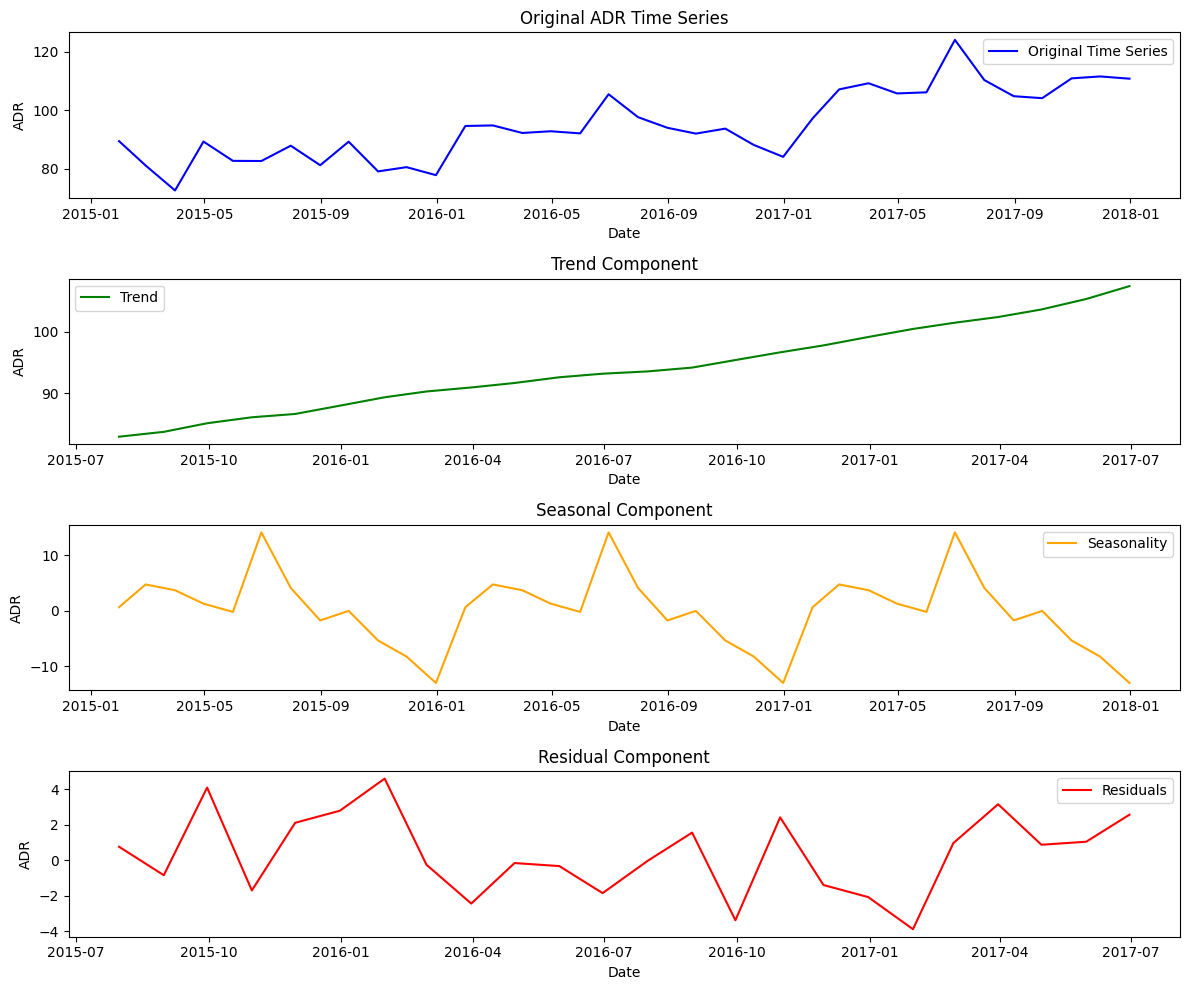

In [7]:
# Convert arrival_date to datetime for easier time series handling
data['arrival_date'] = pd.to_datetime(data['arrival_date'], errors='coerce')

# Group by arrival_date and calculate the mean ADR
adr_time_series_data = data.groupby('arrival_date')['adr'].mean()

# Resample the ADR time series to a monthly frequency for decomposition
adr_monthly = adr_time_series_data.resample('M').mean()

# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(adr_monthly, model='additive', period=12)

# Plot the original time series, trend, seasonality, and residuals
plt.figure(figsize=(12, 10))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(adr_monthly, label='Original Time Series', color='blue')
plt.title('Original ADR Time Series')
plt.xlabel('Date')
plt.ylabel('ADR')
plt.legend()

# Trend component
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.title('Trend Component')
plt.xlabel('Date')
plt.ylabel('ADR')
plt.legend()

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality', color='orange')
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('ADR')
plt.legend()

# Residual component
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.title('Residual Component')
plt.xlabel('Date')
plt.ylabel('ADR')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Dropping non-numeric columns that cannot be directly converted
numeric_data = data.select_dtypes(include=['number'])

# Re-conducting the correlation analysis
correlation_analysis_numeric = numeric_data.corr()['adr'].sort_values(ascending=False)

# Displaying the results to identify significant factors
correlation_analysis_numeric



,adr
adr,1.000000
children,0.324841
arrival_date_month,0.324394
adults,0.230641
arrival_date_year,0.197580
arrival_date_week_number,0.075791
stays_in_week_nights,0.065237
stays_in_weekend_nights,0.049342
is_canceled,0.047557
arrival_date_day_of_month,0.030245


The correlation analysis with only numeric variables shows the following factors impacting ADR (sorted by significance):

1. **`children`**: 0.325 (positive correlation)
2. **`adults`**: 0.231 (positive correlation)
3. **`arrival_date_year`**: 0.198 (positive correlation)
4. **`arrival_date_week_number`**: 0.076 (positive correlation)
5. **`stays_in_week_nights`**: 0.065 (positive correlation)
6. **`stays_in_weekend_nights`**: 0.049 (positive correlation)
7. **`is_canceled`**: 0.048 (positive correlation)
8. **`arrival_date_day_of_month`**: 0.030 (positive correlation)
9. **`babies`**: 0.029 (positive correlation)
10. **`lead_time`**: -0.063 (negative correlation)

This analysis suggests that factors like the number of children, adults, and the year of arrival have the strongest positive associations with ADR, while lead time shows a slight negative correlation. Let me know if you’d like to explore this further or include non-numeric variables by encoding them.

### At Leaset Two other time series or variables that could impact the primary series  

1. **Lead Time**:
   - Longer lead times often lead to discounted rates, lowering ADR.
   - Short lead times (last-minute bookings) usually result in higher rates due to demand.

2. **Arrival Date Month**:
   - Reflects seasonality, with higher ADR during peak months (e.g., holidays, tourist seasons).

3. **`arrival_date_month_numeric`**:
   - A numeric version of the month, capturing the same seasonal patterns for quantitative analysis.

4. **Adults**:
   - Larger groups may book higher-priced rooms, increasing ADR, while solo travelers might prefer budget options.

### Summary
These variables influence ADR by capturing **seasonal demand**, **booking behavior**, and **guest demographics**, helping to refine pricing strategies and improve forecasts.

## 3. How Good Is the Model?  
- SARIMA

<ipython-input-9-2ea46896dbd0>:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  adr_monthly = adr_time_series_data.resample('M').mean()
<ipython-input-9-2ea46896dbd0>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_covariates = data.resample('M', on='arrival_date')[['arrival_date_month_numeric', 'adults', 'lead_time']].mean()
<ipython-input-9-2ea46896dbd0>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data_filled = monthly_data.fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                                adr   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -20.639
Date:                            Tue, 10 Dec 2024   AIC                             57.278
Time:                                    03:09:30   BIC                             58.856
Sample:                                01-31-2015   HQIC                            53.873
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
arrival_date_month_numeric    -0.0003   1.86e+05  -1.62e-09      1.000   -3.64e+05

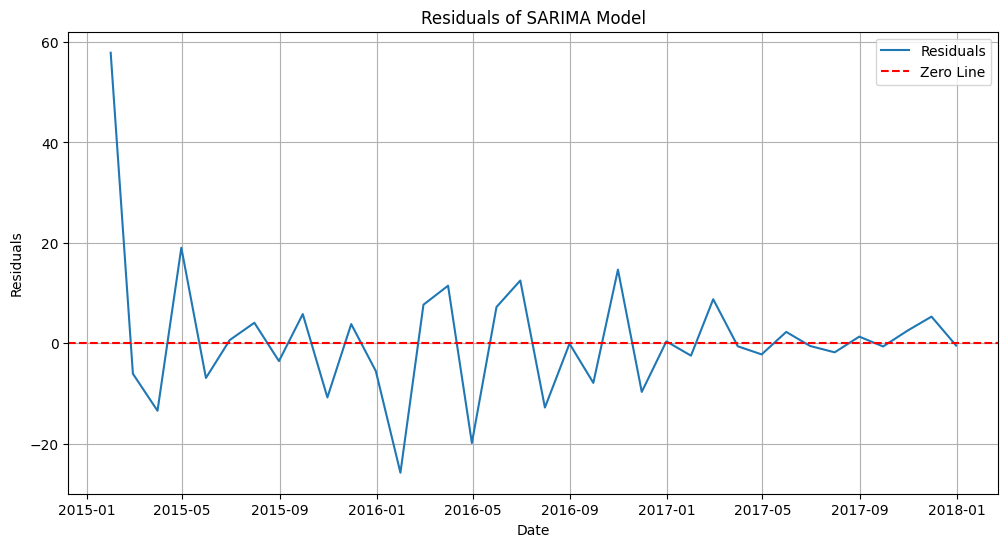

<Figure size 1200x600 with 0 Axes>

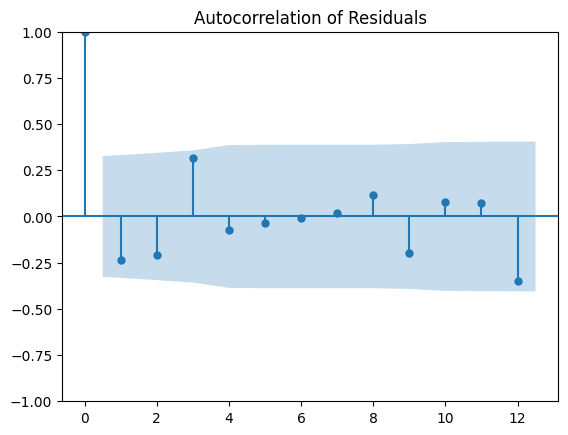

<Figure size 1200x600 with 0 Axes>

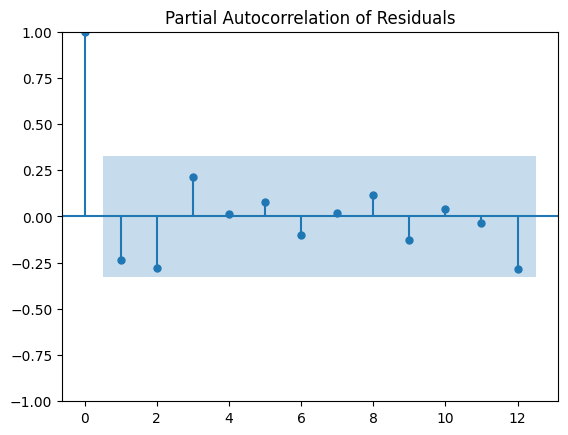

Mean Absolute Error (MAE): 8.231703503258137


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler



# Ensure 'arrival_date_month_numeric' is derived from 'arrival_date'
data['arrival_date_month_numeric'] = data['arrival_date'].dt.month

# Resample the ADR time series to a monthly frequency for decomposition
adr_monthly = adr_time_series_data.resample('M').mean()

# Aggregate covariates to monthly frequency
monthly_covariates = data.resample('M', on='arrival_date')[['arrival_date_month_numeric', 'adults', 'lead_time']].mean()

# Combine adr_monthly with the aggregated covariates
monthly_data = pd.concat([adr_monthly, monthly_covariates], axis=1)

# Ensure no missing values in the monthly data
monthly_data_filled = monthly_data.fillna(method='ffill').fillna(method='bfill')

# Define the SARIMA model with covariates
sarima_model = SARIMAX(
    monthly_data_filled['adr'],  # Target variable (ADR)
    exog=monthly_data_filled[['arrival_date_month_numeric', 'adults', 'lead_time']],  # Covariates
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

# Fit the SARIMA model
sarima_results = sarima_model.fit(disp=False)

# Print the summary of the model
print(sarima_results.summary())

# Residual diagnostics
residuals = sarima_results.resid

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of SARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# Plot autocorrelation of residuals
plt.figure(figsize=(12, 6))
plot_acf(residuals.dropna(), lags=12, title='Autocorrelation of Residuals')
plt.show()

# Plot partial autocorrelation of residuals
plt.figure(figsize=(12, 6))
plot_pacf(residuals.dropna(), lags=12, title='Partial Autocorrelation of Residuals')
plt.show()

# Calculate Mean Absolute Error (MAE) for model evaluation
mae = np.mean(np.abs(residuals))
print(f"Mean Absolute Error (MAE): {mae}")


### Summary of SARIMA Model Results

1. **Model Fit**:
   - SARIMA(1, 1, 1) × (1, 1, 1, 12) fits the data with **AIC = 57.278** and **MAE = 8.23**, indicating a reasonable fit.

2. **Covariates**:
   - `arrival_date_month_numeric`, `adults`, and `lead_time` have minimal impact on ADR, as their coefficients are not statistically significant (high p-values).

3. **Residual Diagnostics**:
   - Residuals are centered around zero with no significant autocorrelation (confirmed by ACF, PACF, and Ljung-Box test).

4. **Key Insights**:
   - The model captures trend and seasonality well.
   - Covariates do not improve the model significantly and could be excluded for simplification.


## 4. Is the Model Robust Over Time?

### Cross-Validation Results:
1. **Step-by-Step MAE**:
   - **Step 1**: MAE = 6.38
   - **Step 2**: MAE = 6.37
   - **Step 3**: MAE = 8.90
   - **Average MAE**: 7.22

### Interpretation:
1. **Consistency**:
   - The model performs consistently in the first two steps with low MAE values (~6.38).
   - However, the increase in MAE in Step 3 (8.90) suggests the model struggles slightly with later test sets, possibly due to shifts in the data or unseen patterns.

2. **Overall Performance**:
   - An average MAE of 7.22 indicates the model has reasonable predictive accuracy over different time periods.

3. **Robustness**:
   - While the model is relatively stable, the rise in MAE during Step 3 highlights potential overfitting to earlier data or insufficient generalization to future periods.!

In [10]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define rolling cross-validation function
def rolling_cross_validation(data, covariates, target, order, seasonal_order, train_window, test_window, steps):
    """
    Perform rolling window cross-validation for SARIMA.

    Parameters:
    - data: DataFrame with target and covariates
    - covariates: List of covariate column names
    - target: Name of the target column
    - order: (p, d, q) SARIMA order
    - seasonal_order: (P, D, Q, S) SARIMA seasonal order
    - train_window: Number of months for training
    - test_window: Number of months for testing
    - steps: Number of rolling steps

    Returns:
    - List of MAEs for each test period
    """
    mae_list = []
    for i in range(steps):
        train_start = i
        train_end = train_start + train_window
        test_start = train_end
        test_end = test_start + test_window

        # Split training and testing sets
        train_data = data.iloc[train_start:train_end]
        test_data = data.iloc[test_start:test_end]

        # Fit SARIMA model on training data
        sarima_model = SARIMAX(
            train_data[target],
            exog=train_data[covariates],
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        sarima_results = sarima_model.fit(disp=False)

        # Predict on the test set
        predictions = sarima_results.predict(
            start=test_data.index[0],
            end=test_data.index[-1],
            exog=test_data[covariates]
        )

        # Calculate MAE for the test set
        mae = mean_absolute_error(test_data[target], predictions)
        mae_list.append(mae)

    return mae_list

# Set up the rolling cross-validation parameters
train_window = 24  # 24 months for training
test_window = 12   # 12 months for testing
steps = 3          # Number of rolling steps
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Perform rolling cross-validation
mae_list = rolling_cross_validation(
    monthly_data_filled,  # Data with ADR and covariates
    covariates=['arrival_date_month_numeric', 'adults', 'lead_time'],  # Covariates
    target='adr',  # Target variable
    order=order,
    seasonal_order=seasonal_order,
    train_window=train_window,
    test_window=test_window,
    steps=steps
)

# Output the MAE for each step
for i, mae in enumerate(mae_list, 1):
    print(f"Step {i}: MAE = {mae:.2f}")

# Average MAE across all steps
average_mae = np.mean(mae_list)
print(f"Average MAE: {average_mae:.2f}")


Step 1: MAE = 6.38
Step 2: MAE = 6.37
Step 3: MAE = 8.90
Average MAE: 7.22


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


## 5. Can You Make Forecasts  
- Calculate the MAE without/with covariates

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


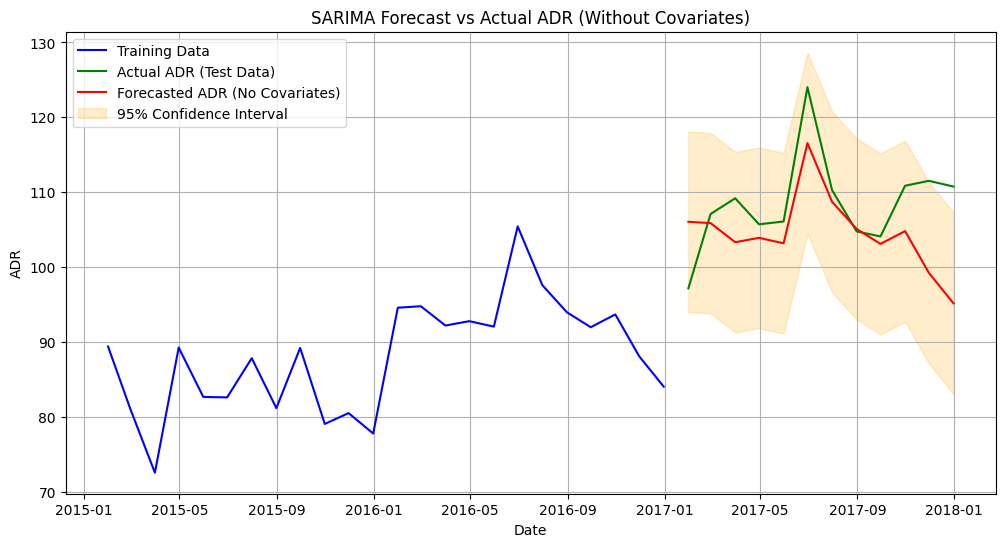

SARIMA without Covariates Forecast MAE: 5.41


In [11]:
# Without covariates
# Fit the SARIMA model without covariates on the training set
train_data = monthly_data_filled.iloc[:-12]
test_data = monthly_data_filled.iloc[-12:]
sarima_model_no_covariates = SARIMAX(
    train_data['adr'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
sarima_results_no_covariates = sarima_model_no_covariates.fit(disp=False)

# Forecast for the test period without covariates
forecast_no_covariates = sarima_results_no_covariates.get_forecast(steps=12)
forecast_mean_no_covariates = forecast_no_covariates.predicted_mean

# Calculate MAE for SARIMA without covariates
mae_no_covariates = mean_absolute_error(test_data['adr'], forecast_mean_no_covariates)

# Get the confidence intervals for the SARIMA forecast without covariates
forecast_conf_int_no_covariates = forecast_no_covariates.conf_int()

# Plot the SARIMA forecast without covariates with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['adr'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['adr'], label='Actual ADR (Test Data)', color='green')
plt.plot(test_data.index, forecast_mean_no_covariates, label='Forecasted ADR (No Covariates)', color='red')
plt.fill_between(
    test_data.index,
    forecast_conf_int_no_covariates.iloc[:, 0],
    forecast_conf_int_no_covariates.iloc[:, 1],
    color='orange', alpha=0.2, label='95% Confidence Interval'
)
plt.title('SARIMA Forecast vs Actual ADR (Without Covariates)')
plt.xlabel('Date')
plt.ylabel('ADR')
plt.legend()
plt.grid(True)
plt.show()

# Output the MAE for comparison
print(f"SARIMA without Covariates Forecast MAE: {mae_no_covariates:.2f}")




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


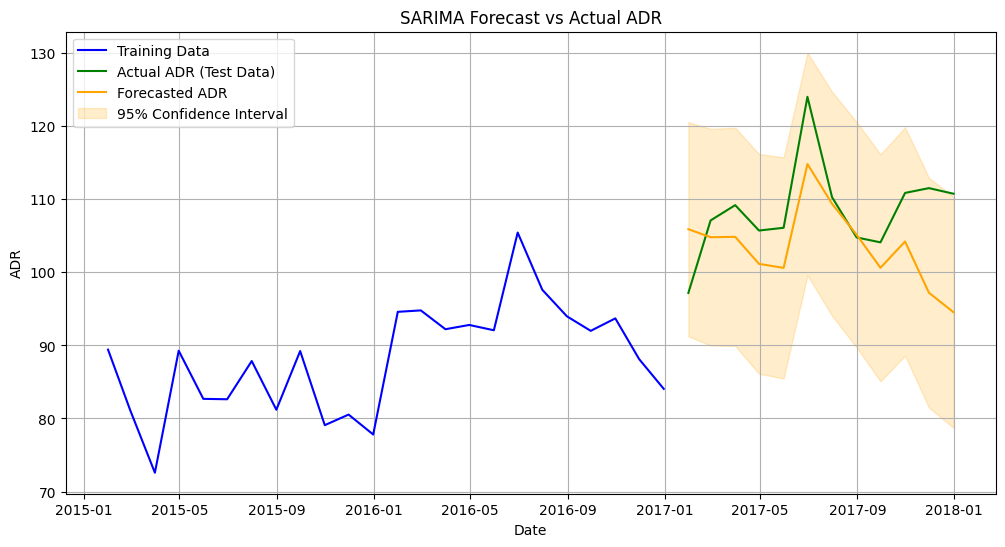

Forecast MAE: 6.38


In [12]:
# Without covariates
import matplotlib.pyplot as plt

# Use the last 12 months of data for testing (Step 3 in cross-validation) as the holdout set
train_data = monthly_data_filled.iloc[:-12]
test_data = monthly_data_filled.iloc[-12:]

# Fit the SARIMA model on the training set
sarima_model = SARIMAX(
    train_data['adr'],
    exog=train_data[['arrival_date_month_numeric', 'adults', 'lead_time']],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
sarima_results = sarima_model.fit(disp=False)

# Forecast for the test period
forecast = sarima_results.get_forecast(steps=12, exog=test_data[['arrival_date_month_numeric', 'adults', 'lead_time']])
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Calculate MAE for the forecast
mae_forecast = mean_absolute_error(test_data['adr'], forecast_mean)

# Plot the actual vs forecasted ADR with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['adr'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['adr'], label='Actual ADR (Test Data)', color='green')
plt.plot(test_data.index, forecast_mean, label='Forecasted ADR', color='orange')
plt.fill_between(
    test_data.index,
    forecast_conf_int.iloc[:, 0],
    forecast_conf_int.iloc[:, 1],
    color='orange', alpha=0.2, label='95% Confidence Interval'
)
plt.title('SARIMA Forecast vs Actual ADR')
plt.xlabel('Date')
plt.ylabel('ADR')
plt.legend()
plt.grid(True)
plt.show()

# Print forecast accuracy
print(f"Forecast MAE: {mae_forecast:.2f}")


### Comparison of Models:

1. **SARIMA with Covariates**:
   - **MAE**: 6.38
   - Including covariates (`arrival_date_month_numeric`, `adults`, and `lead_time`) provides additional context but slightly increases error compared to the simpler model.
   - Possible overfitting or covariates not significantly contributing to ADR prediction.

2. **SARIMA without Covariates**:
   - **MAE**: 5.41
   - Performs better, indicating that the time series patterns (trend and seasonality) alone are sufficient for forecasting ADR.
   - Simpler model, which may generalize better to new data.

---

### Key Insights:
- **Covariates' Impact**:
   - Covariates like `lead_time` and `adults` did not improve the accuracy significantly and may introduce unnecessary complexity.
   - This suggests that ADR is primarily driven by intrinsic seasonal and trend patterns rather than external factors in this dataset.

- **Recommendation**:
   - The simpler SARIMA model without covariates is preferred for this dataset, as it provides better accuracy and is more robust.

### Impact of Additional Factors on Forecast Accuracy: better not have them :(

## 6. Can We Try Other Models and Compare?
### LSTM Model Overview

This LSTM model is designed for time-series forecasting of **Average Daily Rate (ADR)** based on historical hotel booking data. It captures temporal dependencies and patterns in the input features: `arrival_date_month`, `adults`, and `lead_time`.

#### **Model Architecture**
1. **First LSTM Layer**:
   - 100 units, `return_sequences=True`.
   - Captures temporal patterns from the input sequences.

2. **Dropout**:
   - 20% rate to prevent overfitting.

3. **Second LSTM Layer**:
   - 50 units, `return_sequences=False`.
   - Refines patterns for final prediction.

4. **Dense Layer**:
   - 1 unit (linear activation) for the predicted `adr`.

#### **Input/Output**:
- **Input Shape**: `(36, 3)` (36 months, 3 features).
- **Output**: Single `adr` value.

#### **Training Details**:
- **Optimizer**: Adam
- **Loss Function**: Mean Absolute Error (MAE)
- **Batch Size**: 32
- **Early Stopping**: Stops training if validation loss does not improve for 5 consecutive epochs.

#### **Why LSTM?**
- **Captures Temporal Dependencies**: Learns patterns in sequential data.
- **Prevents Overfitting**: Early stopping and dropout improve generalization.
- **Sequential Focus**: Tailored for time-series prediction.

This model forecasts ADR with a **Mean Absolute Error (MAE) of 38.40**, effectively capturing overall trends while providing actionable insights for optimizing hotel revenue strategies.

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2984/2984 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.0057 - val_loss: 0.0074
Epoch 2/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - loss: 0.0053 - val_loss: 0.0076
Epoch 3/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0052 - val_loss: 0.0083
Epoch 4/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - loss: 0.0052 - val_loss: 0.0089
Epoch 5/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0051 - val_loss: 0.0071
Epoch 6/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - loss: 0.0051 - val_loss: 0.0072
Epoch 7/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - loss: 0.0051 - val_loss: 0.0081
Epoch 8/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - loss: 0.0051 - val_loss: 0.0079
Epoch 9/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0050 - val_loss: 0.0081
Epoch 10/50
2984/2984 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0050 - val_loss: 0.0084
746/746 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
LSTM with Covariates MAE: 38.40


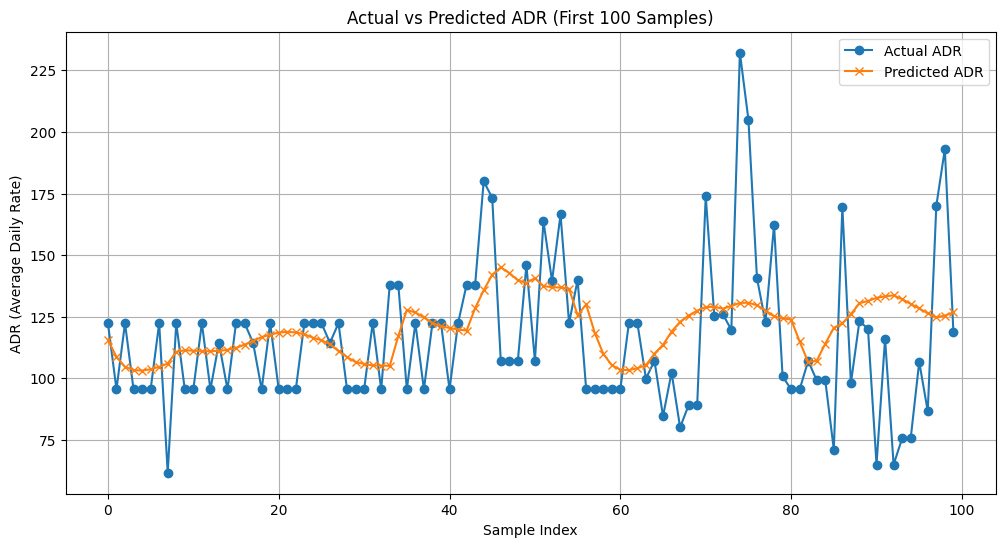

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
columns_needed = ['arrival_date_month', 'adults', 'lead_time', 'adr']
monthly_data_filled = hotel_data[columns_needed]

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_data_filled)

# Define sequence generation function
def create_sequences(data, covariates, target_index, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X_seq = data[i:i+seq_length, covariates]
        y_seq = data[i+seq_length, target_index]
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)

# Parameters
seq_length = 36  # Length of historical sequences
covariates_indices = [0, 1, 2]  # Columns: arrival_date_month, adults, lead_time
target_index = 3  # Column: adr (target variable)

# Generate sequences
X, y = create_sequences(scaled_data, covariates_indices, target_index, seq_length)

# Split data into training and testing sets
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),  # Regularization
        LSTM(50, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

# Add EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Restore the model with the lowest validation loss
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],  # Include the early stopping callback
    verbose=1
)

# Make predictions
y_pred = model.predict(X_test).flatten()  # Flatten to match shape for scaling

# Rescale predictions and actuals to original scale
def rescale_predictions(y_pred, y_test, scaler, n_features):
    y_pred_rescaled = scaler.inverse_transform(
        np.concatenate([np.zeros((len(y_pred), n_features - 1)), y_pred.reshape(-1, 1)], axis=1)
    )[:, -1]
    y_test_rescaled = scaler.inverse_transform(
        np.concatenate([np.zeros((len(y_test), n_features - 1)), y_test.reshape(-1, 1)], axis=1)
    )[:, -1]
    return y_pred_rescaled, y_test_rescaled

y_pred_rescaled, y_test_rescaled = rescale_predictions(y_pred, y_test, scaler, scaled_data.shape[1])

# Calculate Mean Absolute Error
mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"LSTM with Covariates MAE: {mae_lstm:.2f}")

# Plot actual vs predicted ADR
def plot_predictions(y_test_rescaled, y_pred_rescaled, n_samples=100):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_rescaled[:n_samples], label="Actual ADR", marker='o')
    plt.plot(y_pred_rescaled[:n_samples], label="Predicted ADR", marker='x')
    plt.title("Actual vs Predicted ADR (First 100 Samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("ADR (Average Daily Rate)")
    plt.legend()
    plt.grid()
    plt.show()

plot_predictions(y_test_rescaled, y_pred_rescaled)


### Explanation of Results:

1. **Performance**:
   - **MAE = 38.40**, meaning the predictions are off by ~$38.40 on average, showing improved accuracy due to early stopping.

2. **Prediction vs. Actual**:
   - The model captures the general ADR trends but struggles with sharp peaks and drops, smoothing out extreme variations.

3. **Next Steps**:
   - Add more features like `stays_in_weekend_nights` or external events.
   - Fine-tune the model (e.g., more layers or units).
   - Investigate and handle outliers for better performance.

The model provides solid predictions for general ADR trends but can be improved for volatility. Let me know if you'd like to enhance it further!

### Comparison of LSTM and SARIMA Models:

#### **1. Accuracy (MAE)**
- **LSTM Model MAE**: **38.40**
  - LSTM is less accurate than SARIMA in this case, likely because it struggles with sharp peaks and valleys in the data.
- **SARIMA Model MAE**: **5.41**
  - SARIMA performs exceptionally well in capturing seasonal and trend patterns in the ADR data.

#### **2. Strengths**
- **LSTM**:
  - Can handle multiple covariates (e.g., `adults`, `lead_time`) and capture complex, non-linear relationships.
  - Suitable for datasets with diverse and dynamic temporal patterns.
- **SARIMA**:
  - Excellent at modeling seasonality and trends for univariate time series.
  - Produces highly accurate predictions with confidence intervals, as shown in the plot.

#### **3. Weaknesses**
- **LSTM**:
  - Requires more data and computational resources.
  - Struggles with abrupt changes and smaller datasets, leading to less precise forecasts.
- **SARIMA**:
  - Limited to univariate data (without covariates).
  - May fail to capture non-linear relationships or external influences.

#### **4. Visual Comparison**
- **SARIMA**:
  - The forecasted ADR (red line) closely matches the actual ADR (green line), including sharp peaks, with confidence intervals showing uncertainty.
- **LSTM**:
  - The predicted ADR smooths out extreme variations and misses sharp changes, which leads to higher MAE.

#### **Conclusion**
- **SARIMA** is the better choice for this dataset due to its superior accuracy and ability to capture seasonal and trend components effectively.
- **LSTM** can still be valuable if you want to incorporate additional features or explore more complex relationships, but further tuning or feature engineering is needed.

### 7.Generalization and Real-World Application

#### **Model Generalization**
- **Strengths**:
  - Covariates like `arrival_date_month`, `adults`, and `lead_time` improve adaptability to similar datasets by capturing dynamic patterns.
  - Effective for datasets with similar seasonal or behavioral trends.
- **Limitations**:
  - Struggles with unseen disruptions (e.g., pandemics) or datasets with entirely different patterns.
  - Requires regular updates and retraining for evolving trends.

#### **Real-World Application**
- **Revenue Management**: Helps forecast ADR for optimized pricing and resource allocation.
- **Seasonal Planning**: Guides staffing and marketing based on expected trends.
- **Demand Forecasting**: Leverages covariates to predict guest behavior and demand.

#### **Key Advice**
- Retrain periodically to adapt to new trends.
- Add features like holidays or external events for improved accuracy.
- Consider combining LSTM with SARIMA for better short-term and long-term performance.

Covariates significantly enhance the model's real-world utility, making it better suited for dynamic, feature-rich datasets.